### Analyze the music21 Bach chorale's repository

In [2]:
%load_ext autoreload
%autoreload 2

from music21 import corpus
from tqdm import tqdm
import utils as u
import pandas as pd
import os
import music21




In [3]:
MIDI_PATH = './data/midi'

In [26]:
chorales_iterator = corpus.chorales.Iterator()
results = list()
for i in tqdm(chorales_iterator):
    i =  i.parts[0]
    results.append(u.analyze_stream(i))

results_chorales_df = pd.json_normalize(results)
results_chorales_df['label'] = 'chorale'

100%|██████████| 371/371 [00:21<00:00, 17.41it/s]


In [27]:
results_chants_df = pd.DataFrame()
results = list()
for root, dirs, files in os.walk(MIDI_PATH):
    for file in files:
        if file.endswith('.MID'):
            midi_file = os.path.join(root, file)
            midi_stream = music21.converter.parse(midi_file)
            if len(midi_stream.parts) > 1:
                continue
            i = midi_stream.parts[0]
            results.append(u.analyze_stream(i))
results_chants_df = pd.json_normalize(results)

results_chants_df['label'] = 'chant'
results_df = pd.concat([results_chorales_df, results_chants_df], ignore_index=True)


In [28]:
display(results_df)

,mean_interval,unique_notes_per_bar,accidentals,syncopations,unique_durations,notes_per_bar,time_signature,label
0,2.044444,1.952381,21.0,0.190476,2.000000,2.190476,NaN,chorale
1,2.192308,3.153846,13.0,0.153846,1.538462,4.076923,NaN,chorale
2,1.869565,4.000000,10.0,0.300000,1.700000,4.700000,NaN,chorale
3,1.976190,3.300000,10.0,0.200000,1.300000,4.300000,NaN,chorale
4,1.857143,3.764706,17.0,0.294118,1.705882,4.588235,NaN,chorale
...,...,...,...,...,...,...,...,...
374,2.333333,3.250000,4.0,0.500000,2.500000,4.750000,None,chant
375,1.575758,2.888889,9.0,0.777778,2.666667,3.777778,None,chant
376,1.666667,2.666667,6.0,0.333333,2.333333,3.666667,None,chant
377,3.130435,1.777778,9.0,0.222222,1.777778,2.666667,None,chant


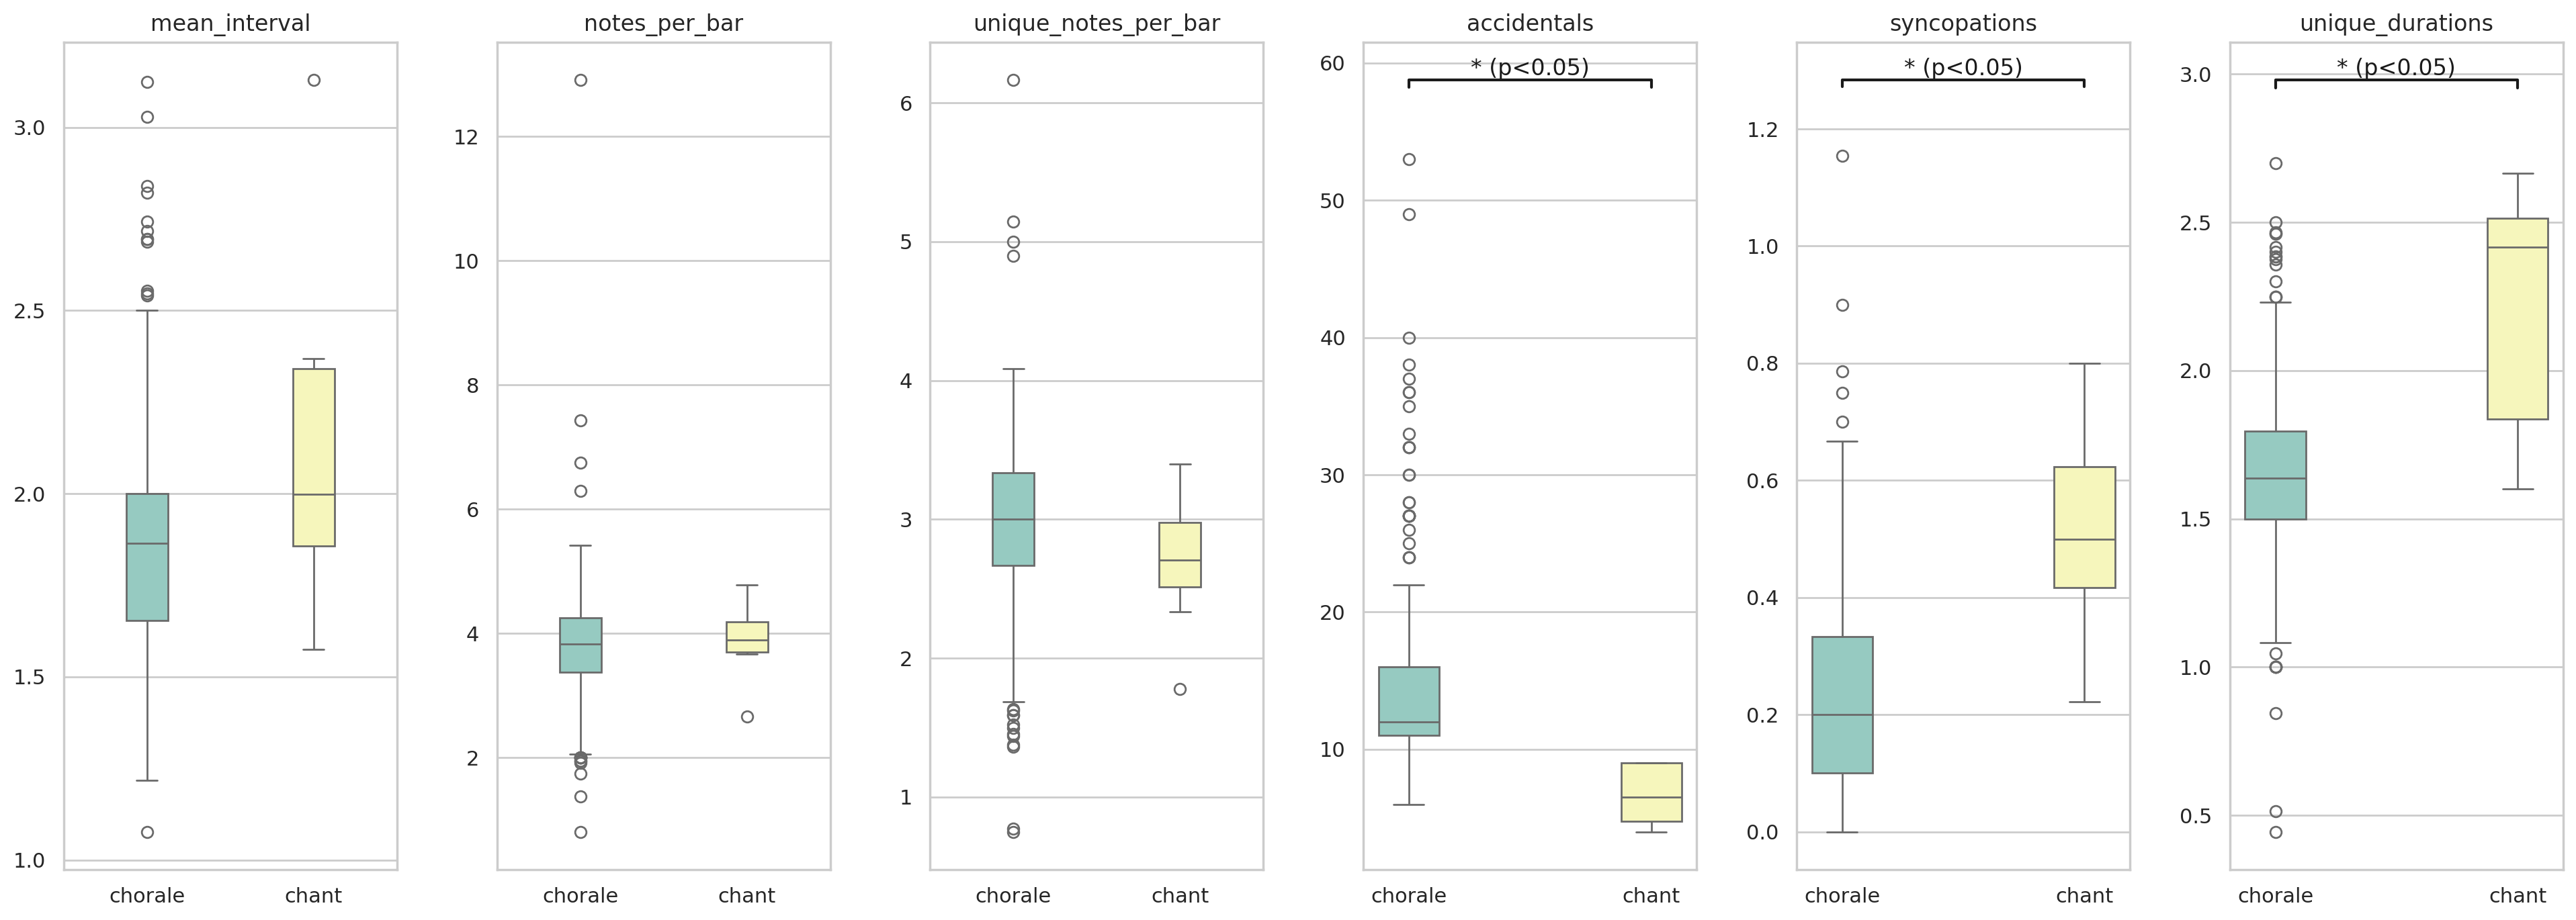

In [48]:

import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
import numpy as np

sns.set(style="whitegrid")
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 6, figsize=(24, 8))
plt.subplots_adjust(wspace=0.3)



metrics = ['mean_interval', 'notes_per_bar', 'unique_notes_per_bar', 
          'accidentals', 'syncopations', 'unique_durations']
results_df.dropna(subset=metrics, inplace=True)

for ax, metric in zip(axes, metrics):
    sns.boxplot(data=results_df, y=metric, x="label", hue="label", ax=ax, gap=0.5, width=0.5, legend=False, palette="Set3")
    
    # Copute Mann-Whitney U test
    groups = results_df.groupby("label")[metric].apply(list)
    W, p = mannwhitneyu(groups["chant"], groups["chorale"])

    # Add significance annotation
    y_offset = ax.get_ylim()[1]/20
    u.add_stat_significance(ax, [(0, 1)], [p], y_offset=y_offset, y_increment=y_offset, h=y_offset/5)

    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title(metric)

plt.show()


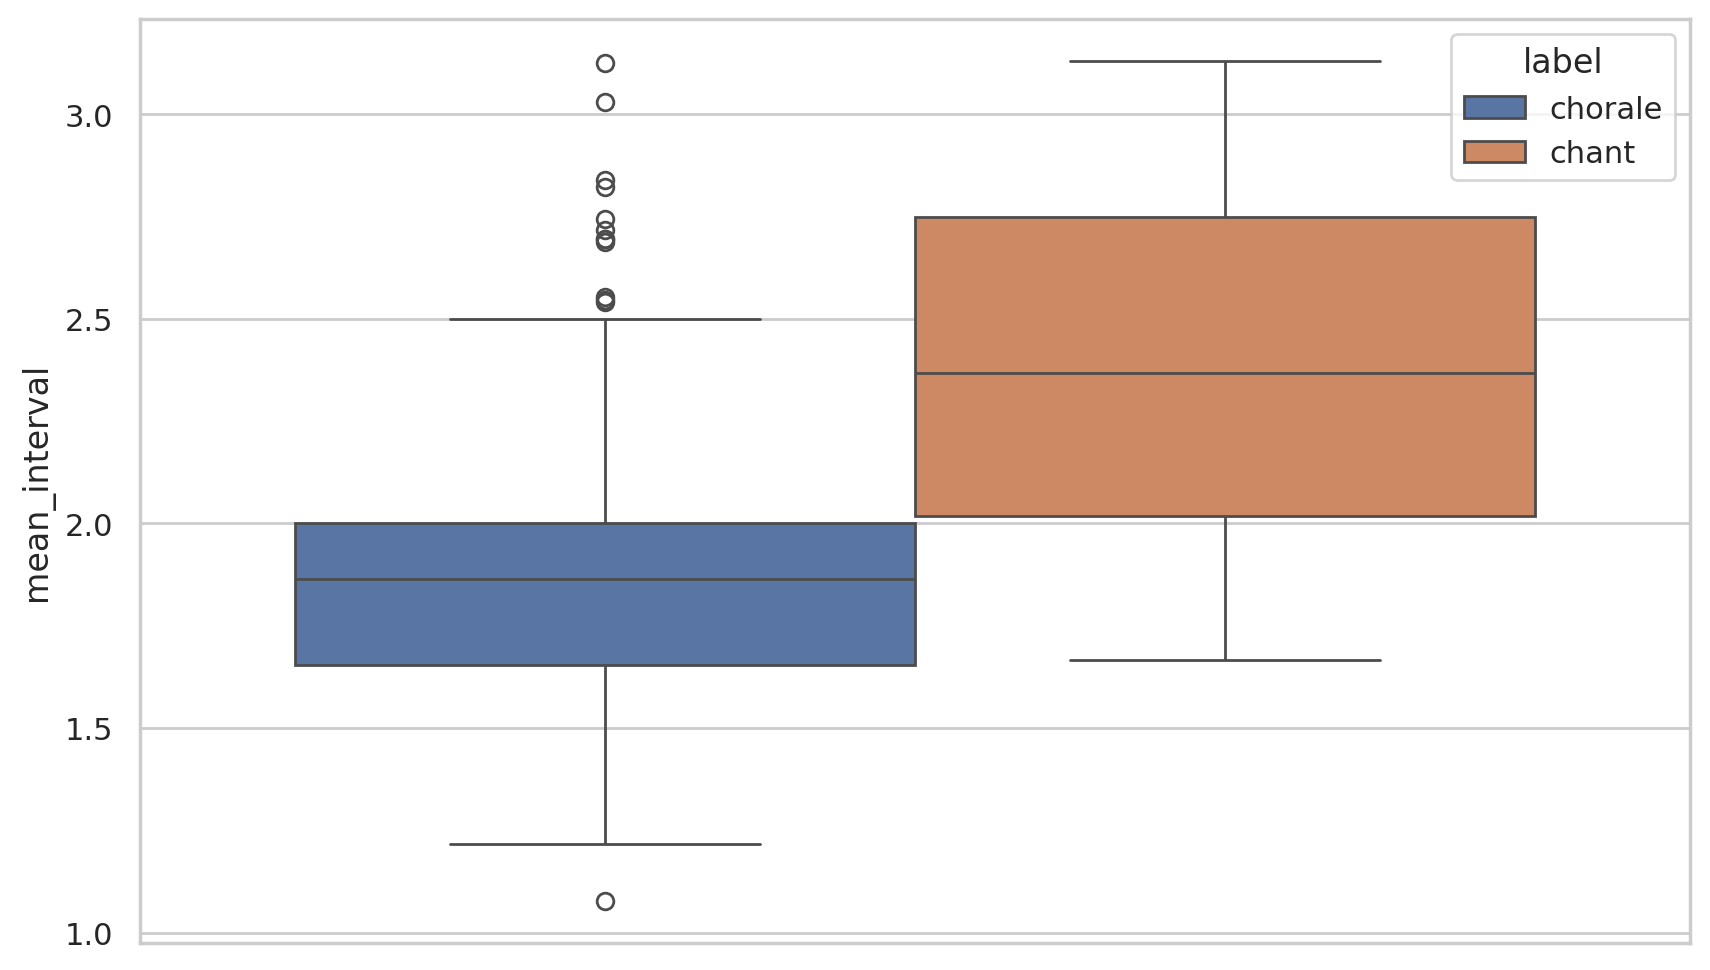

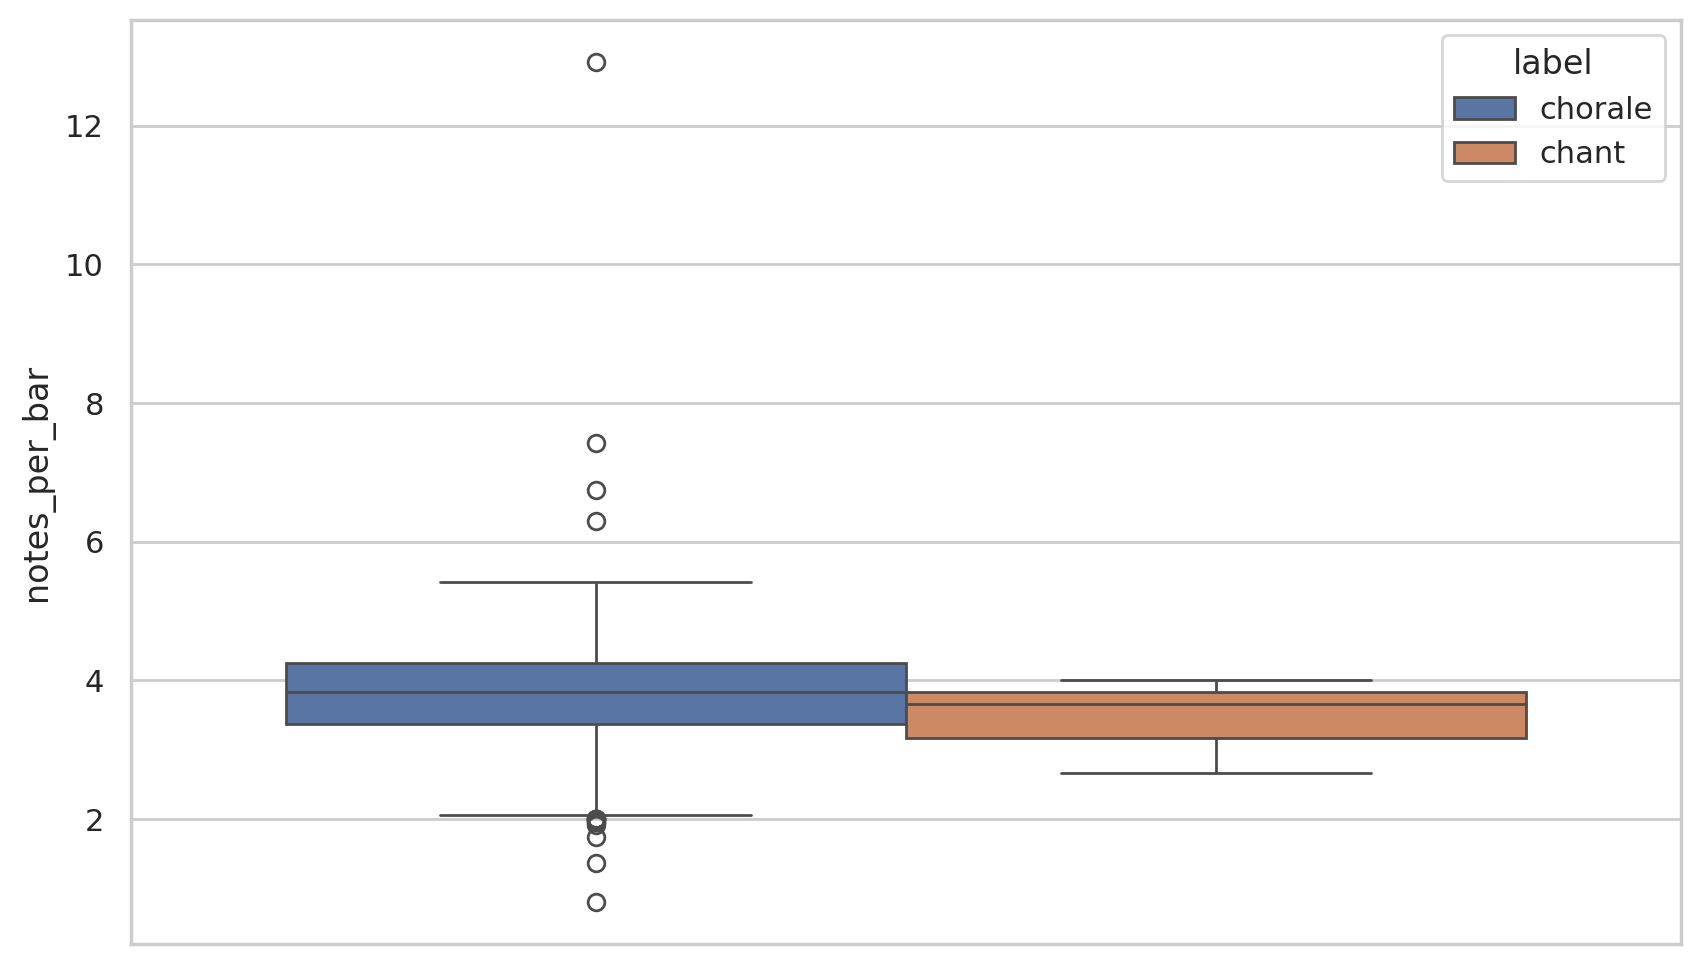

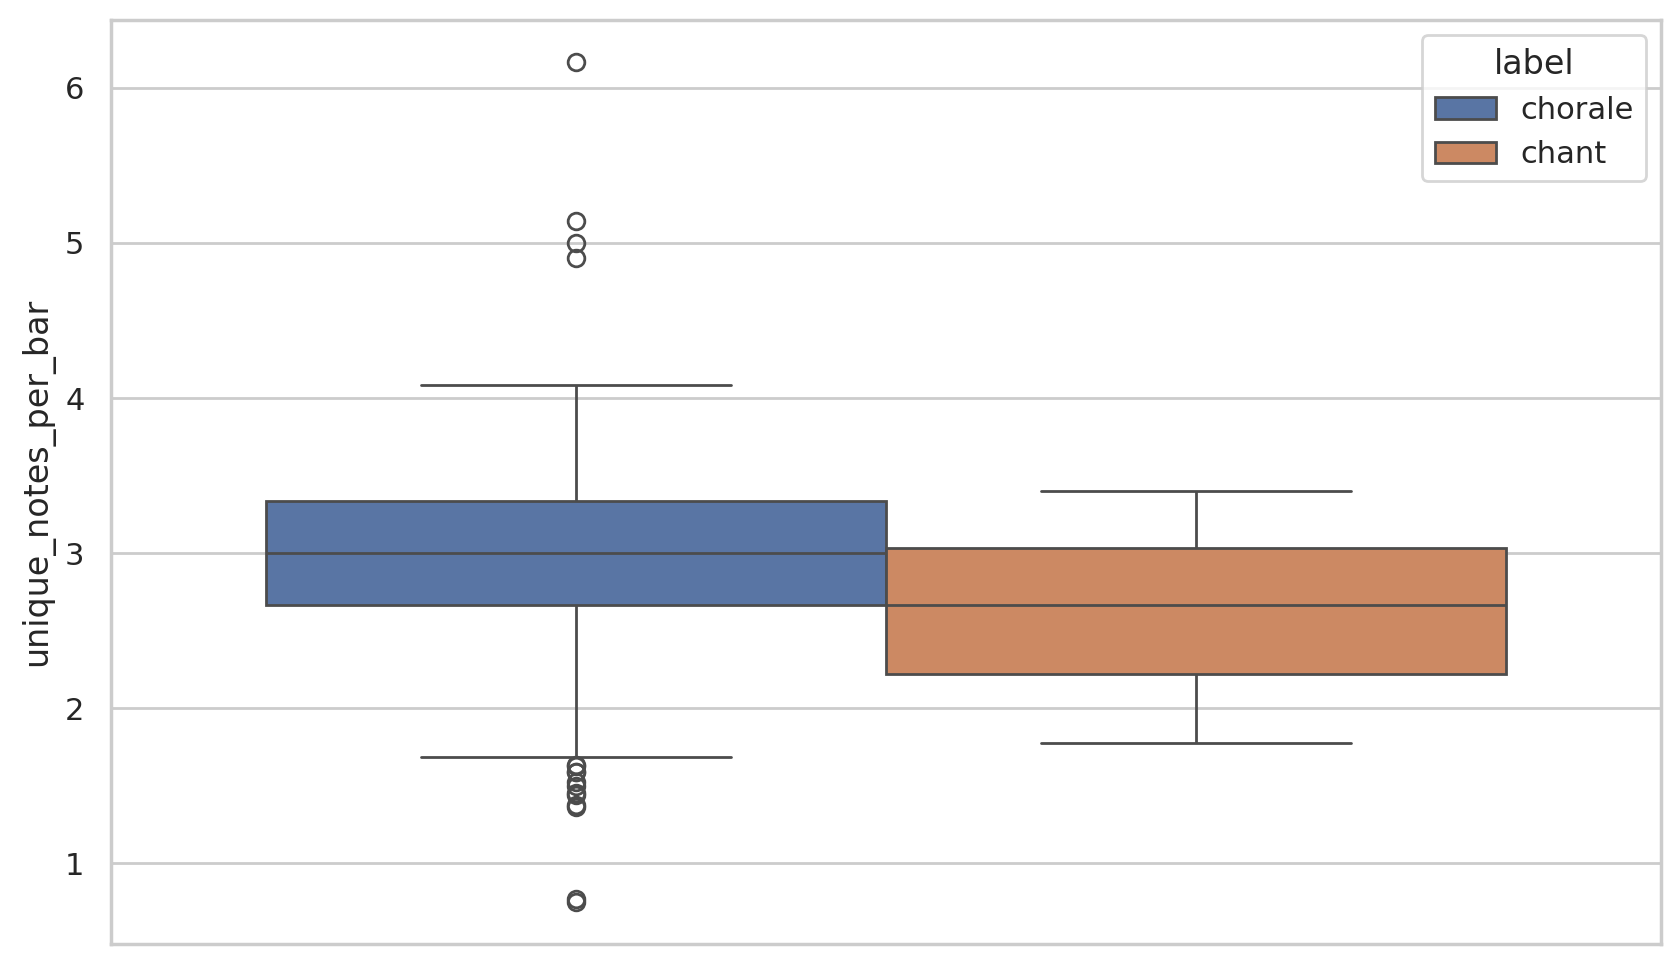

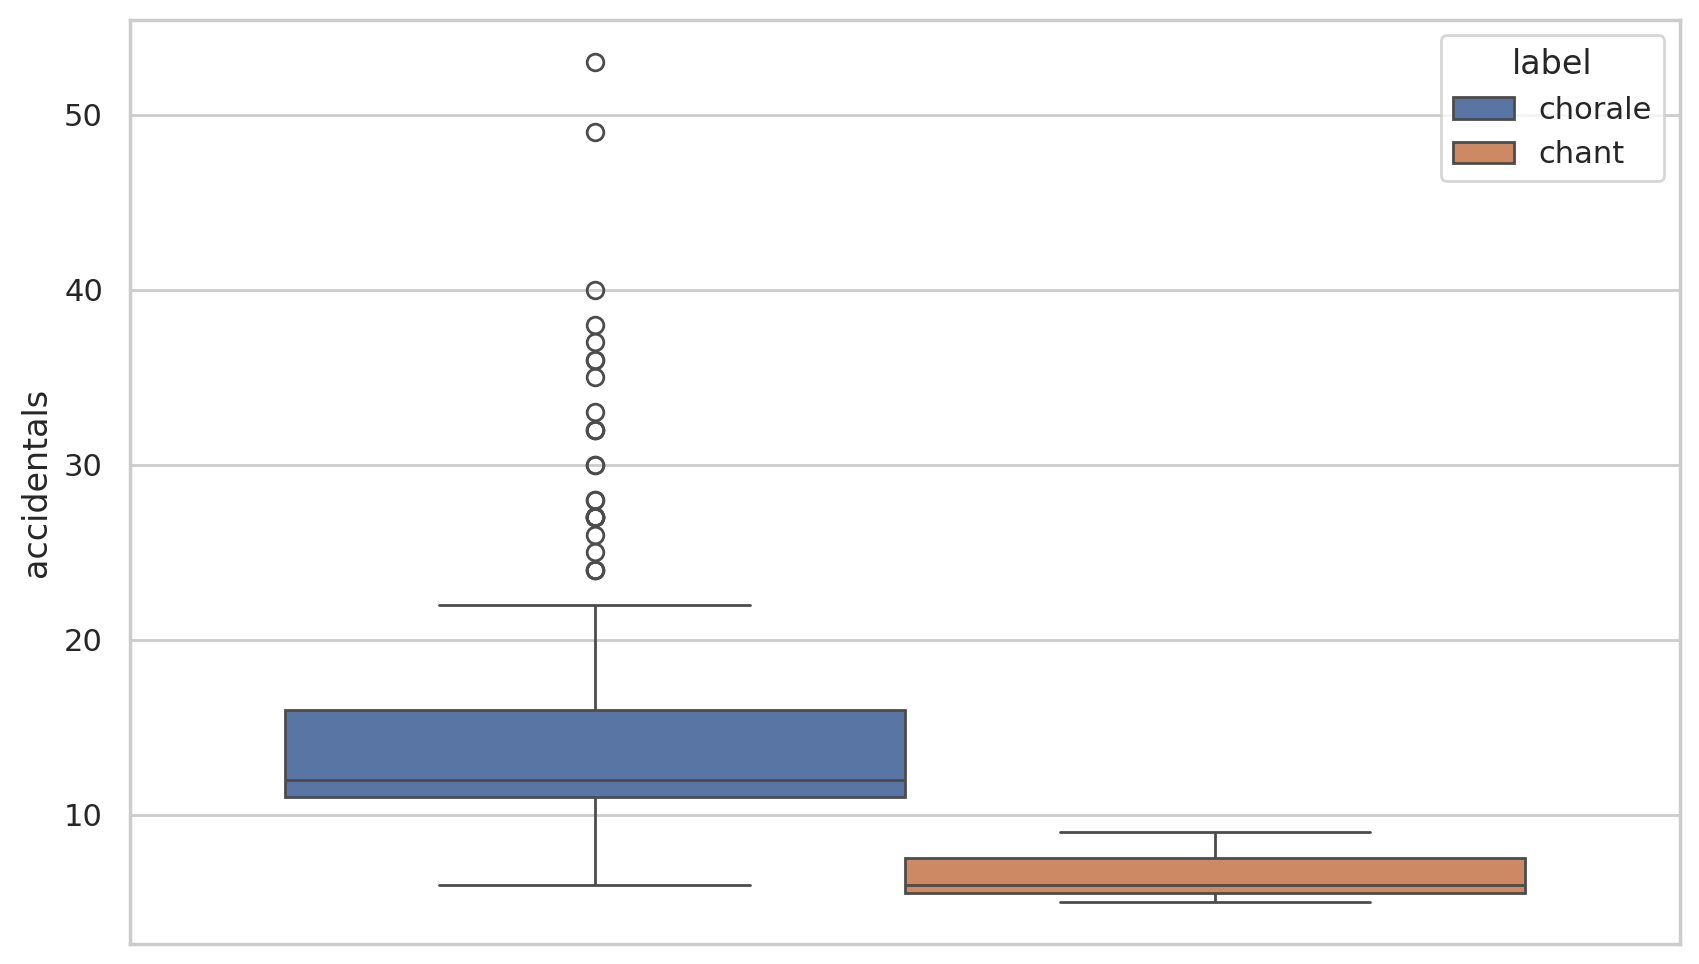

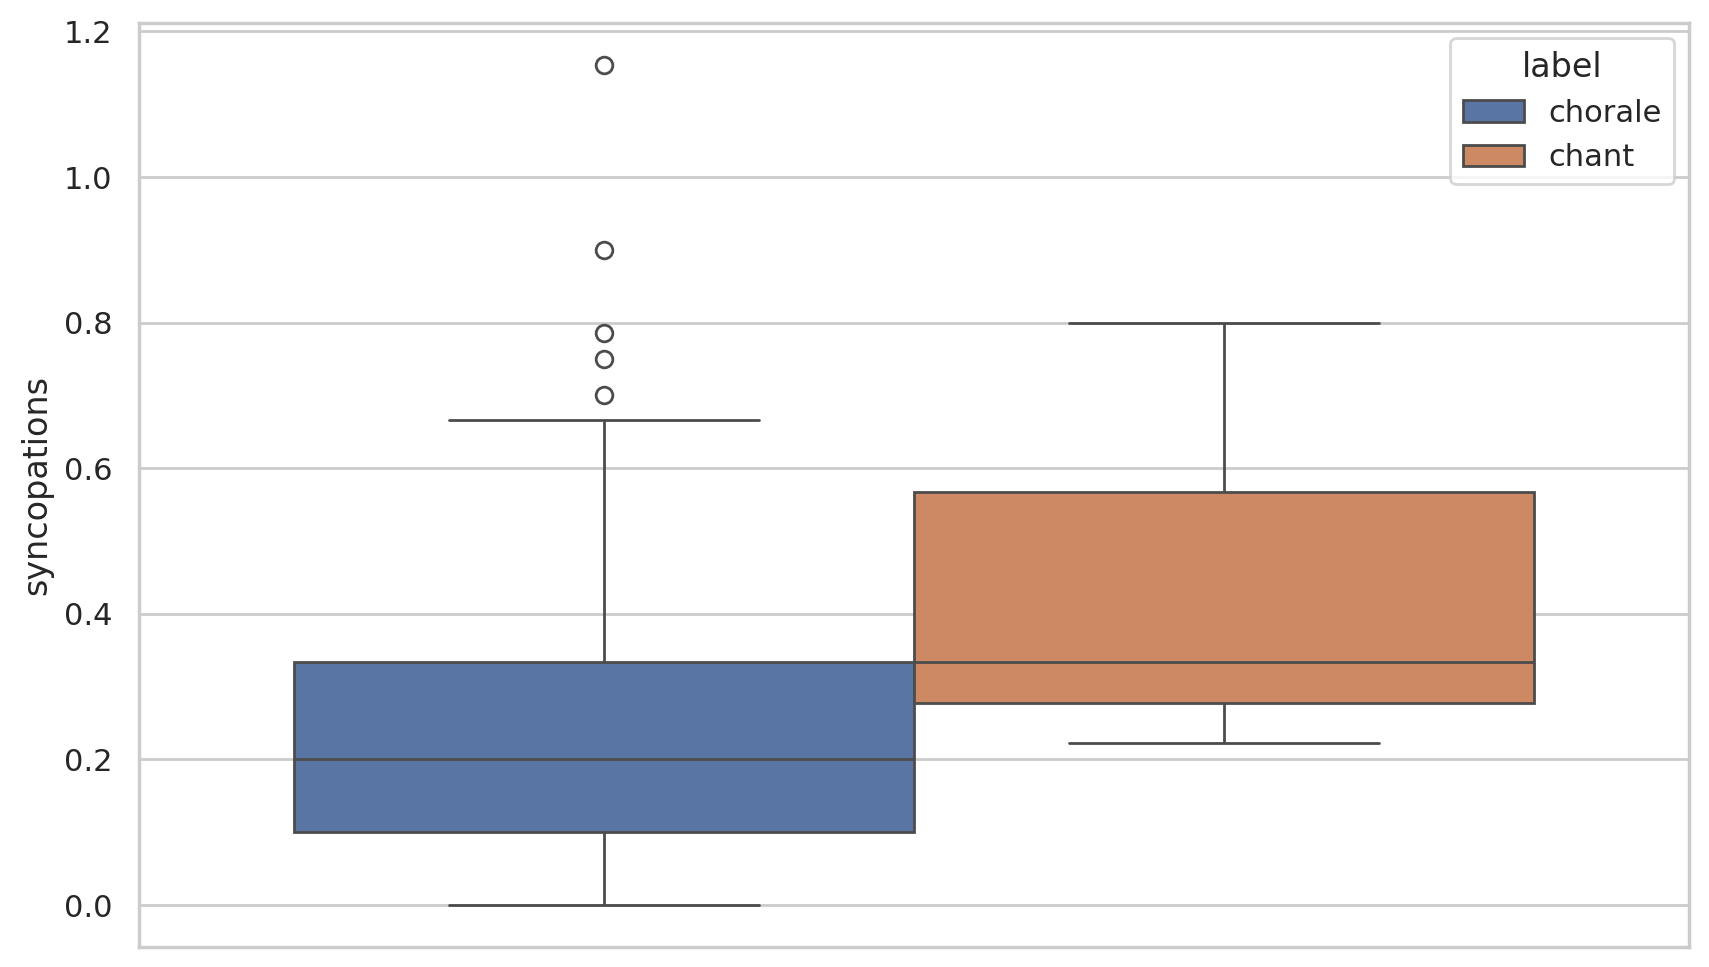

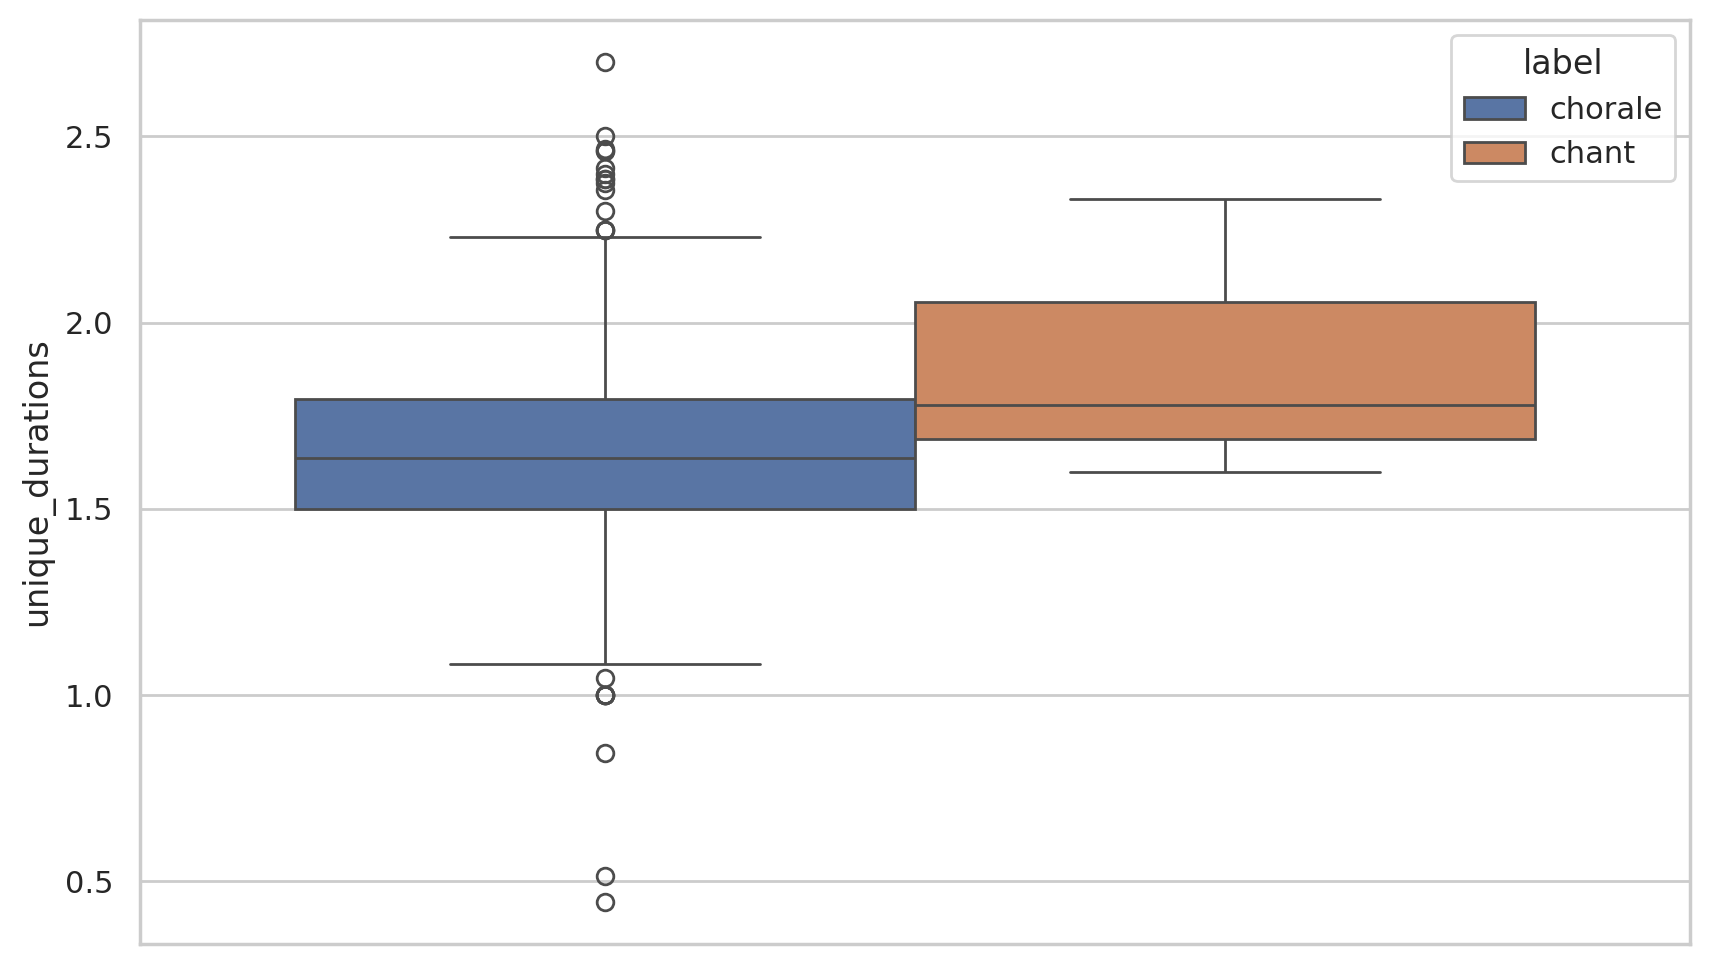

In [16]:

import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")
sns.boxplot(data=results_df, y="mean_interval", hue="label")
plt.show()

sns.boxplot(data=results_df, y="notes_per_bar", hue="label")
plt.show()

sns.boxplot(data=results_df, y="unique_notes_per_bar", hue="label")
plt.show()

sns.boxplot(data=results_df, y="accidentals", hue="label")
plt.show()

sns.boxplot(data=results_df, y="syncopations", hue="label")
plt.show()

sns.boxplot(data=results_df, y="unique_durations", hue="label")
plt.show()